In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display, HTML, Markdown, Latex
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
    
}
div.output_subarea{
    max-width:1200px;
}
div.text_cell_render{
padding: 5em 5em 0.5em 0.5em
}

</style>
"""))

### This is part 2 of the Lending Club project, where I will attempt to improve on the KNN model using a Neural Net 

In [3]:
df = pd.read_pickle("LC_tf.pkl")

### Same dataset as before

In [6]:
df.iloc[:,:5].head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc
1273506,9600.0,9600.0,9600.0,323.42,21900.0
324024,4000.0,4000.0,4000.0,122.93,83000.0
2066630,6025.0,6025.0,6025.0,197.00,52000.0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies',
       'tax_liens', 'grade_dum', 'FullyPaid'],
      dtype='object')

In [9]:
df = df.drop('grade_dum', axis=1)

In [10]:
X = df.drop("FullyPaid", axis=1).values
y = df['FullyPaid'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

In [12]:
scaler = MinMaxScaler()

In [13]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Given the shape of X_train, the Neural Net will have atleast 35 units for the first layer

In [15]:
X_train.shape

(4115, 34)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
early_stop = EarlyStopping(patience=3)

In [18]:
model = Sequential()

model.add(Dense(35, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(35, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])



model.fit(x=X_train, y=y_train,
         epochs=30,
         validation_data=(X_test, y_test),
          callbacks = [early_stop])

model.summary()

Train on 4115 samples, validate on 1764 samples
Epoch 1/30
4115/4115 [==============================] - 1s 149us/sample - loss: 0.6217 - accuracy: 0.7043 - val_loss: 0.5126 - val_accuracy: 0.7982
Epoch 2/30
4115/4115 [==============================] - 0s 43us/sample - loss: 0.5143 - accuracy: 0.7876 - val_loss: 0.4094 - val_accuracy: 0.7982
Epoch 3/30
4115/4115 [==============================] - 0s 48us/sample - loss: 0.4371 - accuracy: 0.7968 - val_loss: 0.2693 - val_accuracy: 0.7982
Epoch 4/30
4115/4115 [==============================] - 0s 42us/sample - loss: 0.3473 - accuracy: 0.8527 - val_loss: 0.1573 - val_accuracy: 0.9666
Epoch 5/30
4115/4115 [==============================] - 0s 43us/sample - loss: 0.2758 - accuracy: 0.8887 - val_loss: 0.0952 - val_accuracy: 0.9700
Epoch 6/30
4115/4115 [==============================] - 0s 44us/sample - loss: 0.2285 - accuracy: 0.9174 - val_loss: 0.0739 - val_accuracy: 0.9734
Epoch 7/30
4115/4115 [==============================] - 0s 43us/sampl

In [19]:
losses = pd.DataFrame(model.history.history)

### With early stopping the model only took about 20 epochs to train. The results below indicate that validation accuracy is always very high, which highlights the skew in the data (most people pay back the loan). Another problem could be that the dataset is simply too small with only around 6k points. Neural nets typically excel at detecting edge cases, which a larger dataset may be able to capture. 

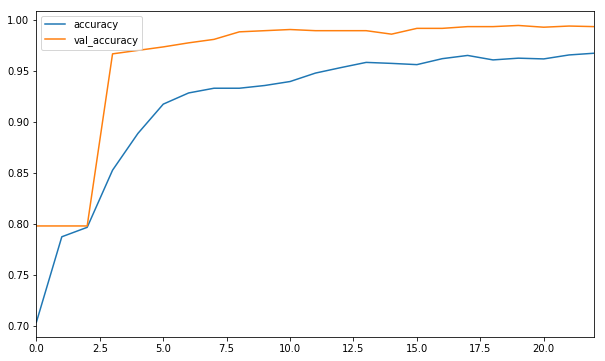

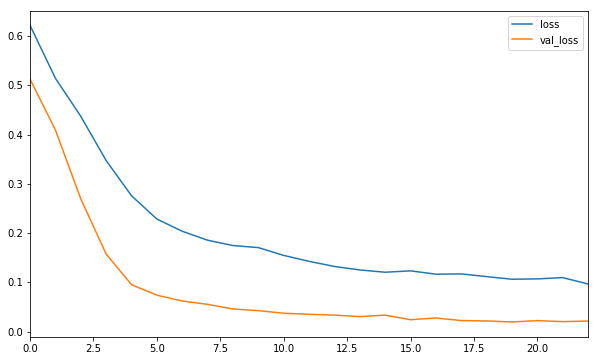

In [20]:
losses[['accuracy', 'val_accuracy']].plot(figsize=[10,6])
losses[['loss', 'val_loss']].plot(figsize=[10,6])

In [21]:
predictions = model.predict_classes(X_test)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

### The Neural Net still crushes the KNN model. The KNN model had an f1-score of about 0.87 for defaulters, which is far lower than the Neural net. Overall, this model is far superior at detecting edge cases and is not harmed by the skew of the data.
Note, that for Fully Paid off loans (1), the f1-score is 100%. The KNN model was already doing quite well with that category so I do not find the perfect score to be suspicious.

In [23]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       356
           1       0.99      1.00      1.00      1408

   micro avg       0.99      0.99      0.99      1764
   macro avg       0.99      0.99      0.99      1764
weighted avg       0.99      0.99      0.99      1764



### If I were to guess at random if potential client would default on a loan or not I would be correct on avearge about $$ \frac{1175*100}{1175+4704} = 20\% $$ 
### of the time. However, with my Neural Net model that accuracy jumps up to about 99%, allowing LC to make better decisions. 

In [20]:
df.groupby('FullyPaid')['loan_amnt'].count()

FullyPaid
0    1175
1    4704
Name: loan_amnt, dtype: int64

In [23]:
# 1175*100/(1175+4704)